In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [1]:
import torch
device = torch.cuda.is_available()
print(device)

True


In [ ]:
!pwd

/content


In [3]:
cd gdrive/MyDrive/Colab\ Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

In [ ]:
# import zipfile
# # 'test.zip'
# dirs = ['train.zip','train_masks.zip']
# for x in dirs:
#     with zipfile.ZipFile("UNet/"+ x,'r') as z:
#         z.extractall(".")


In [5]:
!ls

'Copy of cs725.ipynb'						 train
 seg.ipynb							 train_masks
 SentimentClassification					 UNet
 Sentiment_Classification_and_Word_Embeddings_generation.ipynb


In [6]:
# config
LEARNING_RATE = 1e-4
SPLIT=0.3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
BATCH_SIZE = 4
EPOCHS = 1
NUM_WORKERS = 4
IMAGE_HEIGHT = 572
IMAGE_WIDTH = 572
PIN_MEMORY = True
DATAPATH = ""
TRAIN_IMG_DIR = './train'
TRAIN_MASK_DIR = './train_masks'

cuda


In [7]:
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

In [8]:
#UNet Model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2)        
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
        # expected size
        # encoder (Normal convolutions decrease the size)
        x1 = self.down_conv_1(image)
        # print("x1 "+str(x1.shape))
        x2 = self.max_pool_2x2(x1)
        # print("x2 "+str(x2.shape))
        x3 = self.down_conv_2(x2)
        # print("x3 "+str(x3.shape))
        x4 = self.max_pool_2x2(x3)
        # print("x4 "+str(x4.shape))
        x5 = self.down_conv_3(x4)
        # print("x5 "+str(x5.shape))
        x6 = self.max_pool_2x2(x5)
        # print("x6 "+str(x6.shape))
        x7 = self.down_conv_4(x6)
        # print("x7 "+str(x7.shape))
        x8 = self.max_pool_2x2(x7)
        # print("x8 "+str(x8.shape))
        x9 = self.down_conv_5(x8)
        # print("x9 "+str(x9.shape))

        # decoder (transposed convolutions increase the size)
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        # print(x.shape)
        return x.to(DEVICE)


In [9]:
image = torch.rand((3, 3, 28, 28))
image = image.to(DEVICE)
model = UNet().to(DEVICE)
print(image.shape)
pred = model(image)

torch.Size([3, 3, 28, 28])


In [10]:
print(pred.size())
print(model)

torch.Size([3, 1, 28, 28])
UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0)

In [11]:
#Dataset Preprocseeing
class CarvanaDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
            
        return {"image":image,"mask":mask}

In [12]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

(1280, 1918, 3)


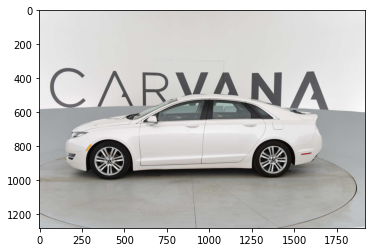

In [13]:
img = np.array(Image.open(TRAIN_IMG_DIR+"/"+images[0]).convert("RGB"))
plt.imshow(img,cmap="gray")
print(img.shape)  #Image is 3 channel

(1280, 1918)


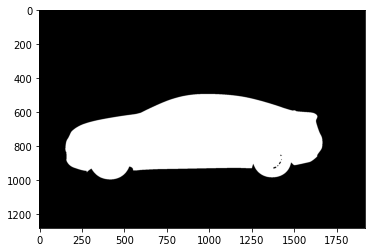

In [14]:
msk = np.array(Image.open(TRAIN_MASK_DIR+"/"+images[0].replace(".jpg","_mask.gif")).convert("L"))
plt.imshow(msk,cmap="gray")
print(msk.shape)  #Mask is 1 channel

In [15]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs =outputs.squeeze(1)
        loss = criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss

In [16]:
def validate(model,dataloader,data,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs =outputs.squeeze(1)
            loss = criterion(outputs,mask)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss

In [17]:
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 12.7 MB/s 
     |████████████████████████████████| 948 kB 64.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=f2c26506c16f3a21d8da253491da0ea1d4eacebcd412487b20fb1a26ad5bde3b
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 

In [19]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])

validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [20]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

In [21]:
train_images_path,val_images_path = train_test_split(images,SPLIT)
val_images_path, test_images_path = train_test_split(val_images_path,0.33)

print(len(images))
print(len(train_images_path))
print(len(val_images_path))
print(len(test_images_path))

train_data = CarvanaDataset(train_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = CarvanaDataset(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)
test_data = CarvanaDataset(test_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)


train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

5088
3562
1023
503


In [22]:
class BCELoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
        super(BCELoss, self).__init__()

  def forward(self, inputs, targets, smooth=1):

    #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')

        return BCE

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):        
        
        inputs = F.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        loss = 1 - dice
        
        return loss

class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)


        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [23]:
# #Different optimizers
optimizer_1 = optim.Adam(model.parameters(),lr=LEARNING_RATE)
optimizer_2 = optim.Adagrad(model.parameters(), lr=LEARNING_RATE)
optimizer_3 = optim.SGD(model.parameters(),lr=LEARNING_RATE)

SGD_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_3, T_max = 2) #have to change T_max

In [24]:
#Different Loss functions
criterion_1 = BCELoss()
criterion_2 = DiceLoss()
criterion_3 = IoULoss()
crterion_4 = FocalLoss()
criterion_5 = DiceBCELoss()

Adam-BCE

In [25]:
# train_loss = []
# val_loss =[]
# model = UNet().to(DEVICE)
# EPOCHS = 5

# optimizer_1 = optim.Adam(model.parameters(),lr=LEARNING_RATE)
# criterion_1 = BCELoss()

# for epoch in range(EPOCHS):
#     print(f"Epoch {epoch+1} of {EPOCHS}")
#     train_epoch_loss = fit(model, train_dataloader, train_data,optimizer_1,criterion_1)
#     val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion_1)
#     train_loss.append(train_epoch_loss)
#     val_loss.append(val_epoch_loss)
#     print(f"Train Loss: {train_epoch_loss:.4f}")
#     print(f'Val Loss: {val_epoch_loss:.4f}')

#     torch.save({
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer_1.state_dict(),
#     'loss': criterion_1,
# }, "/content/gdrive/MyDrive/Colab Notebooks/UNet/seg_BCE_Adam_model_.pth"+str(epoch))



In [26]:
# # loss plots
# plt.figure(figsize=(10, 7))
# plt.plot(train_loss, color="orange", label='train loss')
# plt.plot(val_loss, color="red", label='validation loss')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/UNet/loss(BCE_Adam).png")
# plt.show()

Adam-Dice

In [ ]:
# train_loss = []
# val_loss =[]
# model = UNet().to(DEVICE)
# EPOCHS = 5

# optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
# criterion = DiceLoss()

# for epoch in range(3,EPOCHS):
#     print(f"Epoch {epoch+1} of {EPOCHS}")
#     train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
#     val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
#     train_loss.append(train_epoch_loss)
#     val_loss.append(val_epoch_loss)
#     print(f"Train Loss: {train_epoch_loss:.4f}")
#     print(f'Val Loss: {val_epoch_loss:.4f}')

#     torch.save({
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': criterion,
# }, "/content/gdrive/MyDrive/Colab Notebooks/UNet/seg_Dice_Adam_model_"+str(epoch)+'.pth')



Epoch 4 of 5
-------------Training---------------


  0%|          | 0/890 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
891it [49:21,  3.32s/it]



--------Validating---------



256it [11:01,  2.58s/it]


Train Loss: 0.1907
Val Loss: 0.0842
Epoch 5 of 5
-------------Training---------------


891it [23:21,  1.57s/it]



--------Validating---------



256it [03:23,  1.26it/s]


Train Loss: 0.0560
Val Loss: 0.0322


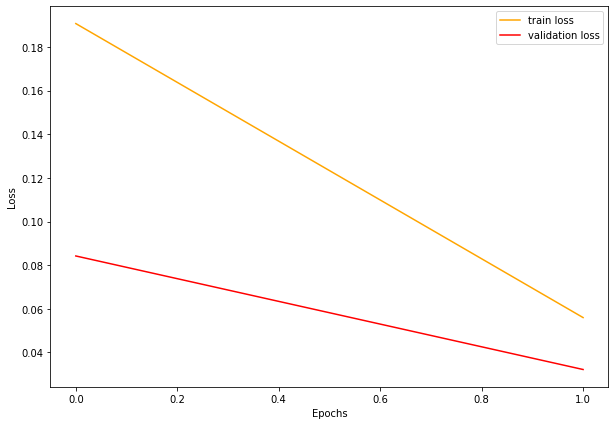

In [ ]:
# # loss plots
# plt.figure(figsize=(10, 7))
# plt.plot(train_loss, color="orange", label='train loss')
# plt.plot(val_loss, color="red", label='validation loss')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/UNet/loss(Dice_Adam).png")
# plt.show()

Adam-IOU

In [ ]:
train_loss = []
val_loss =[]
model = UNet().to(DEVICE)
EPOCHS = 5

optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = IoULoss()

for epoch in range(1,EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "/content/gdrive/MyDrive/Colab Notebooks/UNet/seg_IOU_Adam_model_.pth"+str(epoch))



Epoch 2 of 5
-------------Training---------------


  0%|          | 0/890 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
891it [1:07:39,  4.56s/it]



--------Validating---------



256it [16:55,  3.96s/it]


Train Loss: 0.2973
Val Loss: 0.1515
Epoch 3 of 5
-------------Training---------------


891it [23:23,  1.57s/it]



--------Validating---------



256it [03:19,  1.28it/s]


Train Loss: 0.0827
Val Loss: 0.0522
Epoch 4 of 5
-------------Training---------------


  5%|▍         | 43/890 [01:08<22:25,  1.59s/it]

In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/UNet/loss(IOU_Adam).png")
plt.show()

Adam-DiceBCE

In [ ]:

train_loss = []
val_loss =[]
model = UNet().to(DEVICE)
EPOCHS = 5

optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = DiceBCELoss()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "/content/gdrive/MyDrive/Colab Notebooks/UNet/seg_DiceBCE_Adam_model_.pth"+str(epoch))


In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/UNet/loss(DiceBCE_Adam).png")
plt.show()

In [ ]:
data = train_data.__getitem__(100)
plt.imshow(data['mask'],cmap="gray")
print(train_data.__getitem__(0)['mask'].shape)

In [ ]:
# for Testing on Single datapoint after training
# plt.imshow(np.transpose(np.array(data['image']),(1,2,0)),cmap="gray")
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
# model = UNet()
output = model(img)
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
print(output.shape)
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")

References:

https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook#Dice-Loss

https://www.kaggle.com/code/nandwalritik/u-net-pytorch/notebook

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/